In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [5]:
from Datos import Datos
import EstrategiaParticionado
import Clasificador

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

clasificador = Clasificador.Clasificador()

In [6]:
final_results_dict = {}

# <font color='red'>0. Particionado</font>

Probaremos la clase Particion y EstrategiaParticionado con el conjunto de datos 'tic-tac-toe'.

In [7]:
db = Datos('../ConjuntosDatos/tic-tac-toe.data')

In [8]:
n,m = db.datos.shape
n

958

Tenemos 958 ejemplos de entrenamiento. Vamos a comprobar el correcto funcionamiento del módulo de particionado con los tres siguientes modelos:
- validacion simple con 80% de los ejemplos para el conjunto de entrenamiento (20% test).
- validacion simple (80% - 20% también), pero con 3 repeticiones.
- validacion cruzada

### 0.1 Validación simple

In [9]:
simple_strat = EstrategiaParticionado.ValidacionSimple(0.8)
simple_strat.creaParticiones(db.datos)

len_indices_train = len(simple_strat.particiones[0].indicesTrain)
len_indices_test = len(simple_strat.particiones[0].indicesTest)

print("Indices train:", len_indices_train)
print("Indices train teoricos:", int(0.8*n))
print("Indices test:", len_indices_test)
print("Indices test teoricos:", n - int(0.8*n))

Indices train: 766
Indices train teoricos: 766
Indices test: 192
Indices test teoricos: 192


In [10]:
print("Train:", simple_strat.particiones[0].indicesTrain[:10])
print("Test:", simple_strat.particiones[0].indicesTest[:10])

Train: [622, 262, 312, 211, 358, 0, 813, 426, 920, 642]
Test: [11, 12, 13, 16, 20, 21, 24, 32, 35, 46]


### 0.2 Validación simple con 3 repeticiones

Comprobamos que para cada partición simple (una por repetición), el número esperado de ejemplos del conjunto de entrenamiento se corresponde con el número real. Análogamente, comprobamos que el número esperado de ejemplos del conjunto de test se corresponde con el número teórico.

Por lo tanto la siguiente celda debería imprimir 'True' tantas veces como comprobaciones

In [11]:
REPS = 3
simple_strat_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=REPS)
simple_strat_rep3.creaParticiones(db.datos)

for i in range(REPS):
    print(len(simple_strat_rep3.particiones[i].indicesTrain) == int(n*0.8))
    print(len(simple_strat_rep3.particiones[i].indicesTest) == (n-int(n*0.8)))

True
True
True
True
True
True


In [12]:
print("Train:", simple_strat_rep3.particiones[REPS-1].indicesTrain[:10])
print("Test:", simple_strat_rep3.particiones[REPS-1].indicesTest[:10])

Train: [72, 560, 440, 421, 146, 619, 341, 205, 431, 794]
Test: [14, 23, 27, 36, 38, 39, 43, 54, 63, 66]


### 0.3 Validación cruzada

Comprobamos que para cada partición (una por kfold), el número esperado de ejemplos del conjunto de entrenamiento se corresponde con el número real. Análogamente, comprobamos que el número esperado de ejemplos del conjunto de test se corresponde con el número teórico.

Por lo tanto la siguiente celda debería imprimir 'True' tantas veces como comprobaciones

In [13]:
KFOLDS = 5
cross_val = EstrategiaParticionado.ValidacionCruzada(k_fold=KFOLDS)
cross_val.creaParticiones(db.datos)

for i in range(KFOLDS):
    print(len(cross_val.particiones[i].indicesTrain) == (n-int(n/KFOLDS)))
    print(len(cross_val.particiones[i].indicesTest) == int(n/KFOLDS))

True
True
True
True
True
True
True
True
True
True


In [14]:
print("Train:", cross_val.particiones[KFOLDS-1].indicesTrain[:10])
print("Test:", cross_val.particiones[KFOLDS-1].indicesTest[:10])

Train: [0 1 2 3 4 5 6 7 8 9]
Test: [764 765 766 767 768 769 770 771 772 773]


Visto que funciona correctamente el módulo de particionado, recalcamos el hecho de que este <b>no se encarga de embarajar los ejemplos de entrenamiento</b>. Esto se debe hacer <b>antes del entrenamiento</b>.

En cuanto a las <b>estrategias de particionado</b>, cada una tiene sus particularidades.

El método <b>validación simple</b> es el más sencillo, pero el hecho de que los conjuntos <b>train y test sean escogidos aleatoriamente</b> para cada repetición <b>induce a variaciones</b> en ejecuciones sucesivas. Esto es debido a que las observaciones se distribuyen aleatoriamente entre los conjuntos de train y test y si por casualidad caen muy pocas observaciones o demasiadas de un tipo concreto en el conjunto de train podemos tener prblemas tanto de  <b>"overfitting"</b> como <b>"underfitting"</b>.

La <b>validación cruzada</b> al <b>comparar los datos por lotes, todos con todos</b> consigue obtener <b>aproximaciones de error más estables</b> y optimiza el <b>problema del ajuste</b> comentado anteriormente. Por tanto la <b>tasa de error</b> obtenida por validación cruzada suelen ser <b>mejor y más fiable</b>.

# <font color='red'>1. Entrenamiento y clasificación con Clasificador.py</font>


## <font color='blue'> 1.1 Dataset tic-tac-toe </font>

In [15]:
dataset_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
ndata, ncols = dataset_ttt.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 958 , Numero de columnas: 10


In [16]:
np.random.shuffle(dataset_ttt.datos) # Importante embarajar los datos!

NB = Clasificador.ClasificadorNaiveBayes()
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)

### 1.1.1 Validación simple

In [17]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [19]:
errores = clasificador.validacion(strat_simple, dataset_ttt, NB)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple, dataset_ttt, NB_noLaplace)
print("Sin Laplace:", errores2)

# We will use this result later
final_results_dict['clasificador_val_simple_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.29166666666666663]
Sin Laplace: [0.3125]


Podemos apreciar en este pequeño subapartado que el entrenamiento usando la corrección de Laplace es más preciso que el entrenamiento obviando la propia corrección.

### 1.1.2 Validación simple con varias repeticiones (3 reps)

In [20]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [22]:
errores = clasificador.validacion(strat_simple_rep3, dataset_ttt, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3, dataset_ttt, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_val_simple_rep3_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_rep3_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.27083333333333337, 0.32291666666666663, 0.30208333333333337]
Error medio con Laplace: 0.2986111111111111 +- 0.021404215288086694
Errores sin Laplace: [0.3125, 0.296875, 0.27604166666666663]
Error medio sin Laplace: 0.2951388888888889 +- 0.014934592477504576


Cuando repetimos varias veces el entrenamiento con una estrategia de particionado simple el error usando la corrección de Laplace es muy similar al error que obtenemos al no usarla. Sabiendo esto, podríamos desactivar Laplace para ganar eficiencia computacional y poder entrenar un mayor conjunto de datos en menos tiempo.

### 1.1.3 Validación Cruzada (5 folds)

In [23]:
strat_cross = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [28]:
errores = clasificador.validacion(strat_cross, dataset_ttt, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross, dataset_ttt, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_cross_val_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_cross_val_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.31413612565445026, 0.2984293193717278, 0.3036649214659686, 0.2774869109947644, 0.2879581151832461]
Error medio con Laplace: 0.29633507853403146 +- 0.012652404160832003
Errores sin Laplace: [0.2722513089005235, 0.2722513089005235, 0.2931937172774869, 0.32460732984293195, 0.32984293193717273]
Error medio sin Laplace: 0.29842931937172773 +- 0.024779391761673795


El entrenamiento con la corrección de Laplace sigue siendo más preciso, pero la diferencia es ínfima. Podemos, de nuevo, sugerir desactivar dicho método para ganar eficiencia.

Por otro lado, ahora nos centramos en la comparación de los resultados de las tres estrategias de particionado. En una futura sección del notebook se resumirán todos los resultados obtenidos, pero podemos hacer un pequeño comentario ahora sobre el entrenamiento y clasificación del conjunto de datos 'tic-tac-toe'.

Podemos observar que los errores obtenidos no son muy dispares. Parece que la media del error se distribuye entorno al 29% con una ligera desviación típica. Aún no podemos distinguir la mejor estrategia de las tres con estos resultados.

## <font color='blue'> 1.2 Dataset German </font>

In [38]:
dataset_ger = Datos("../ConjuntosDatos/german.data")
ndata, ncols = dataset_ger.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [39]:
np.random.shuffle(dataset_ger.datos)

### 1.2.1 Validación simple

In [48]:
strat_simple_ger = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_ger, dataset_ger, NB)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple_ger, dataset_ger, NB_noLaplace)
print("Sin Laplace:", errores2)

# We will use this result later
final_results_dict['clasificador_val_simple_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.24]
Sin Laplace: [0.28]


Nuevo conjunto de datos, pero los resultados son similares: la corrección de Laplace ayuda, pero tampoco hace milagros.

### 1.2.2 Validación simple con varias repeticiones (3 reps)

In [44]:
strat_simple_rep3_ger = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_ger, dataset_ger, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_ger, dataset_ger, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_val_simple_rep3_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_val_simple_rep3_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.24, 0.21999999999999997, 0.245]
Error medio con Laplace: 0.235 +- 0.010801234497346443
Errores sin Laplace: [0.275, 0.20999999999999996, 0.30500000000000005]
Error medio sin Laplace: 0.26333333333333336 +- 0.03965125751123443


En este caso, parece que realizar varias repeticiones de un entrenamiento con una estrategia de particionado simple no ayuda a reducir el error. No obstante, parece que la corrección de Laplace en este conjunto de datos tiene una mayor presencia que el conjunto de datos anterior. Esto es debido, posiblemente, a que no todos los atributos son discretos, y la corrección de Laplace sólo se realiza sobre este tipo de atributos.

### 1.2.3 Validación cruzada (5 folds)

In [46]:
strat_cross_ger = EstrategiaParticionado.ValidacionCruzada(k_fold=3)

errores = clasificador.validacion(strat_cross_ger, dataset_ger, NB)
print("Errores con Laplace:", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_ger, dataset_ger, NB_noLaplace)
print("Errores sin Laplace:", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['clasificador_cross_val_ger'] = [np.mean(errores), np.std(errores)]
final_results_dict['clasificador_cross_val_ger_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace: [0.24024024024024027, 0.3153153153153153, 0.21321321321321318]
Error medio con Laplace: 0.25625625625625625 +- 0.04319409211289574
Errores sin Laplace: [0.2432432432432432, 0.2792792792792793, 0.21321321321321318]
Error medio sin Laplace: 0.24524524524524524 +- 0.027008483610074185


En este caso concreto, la corrección de Laplace no ha aportado nada positivo, de hecho el error es mayor. Nos empezamos a cuestionar si en esta base de datos utilizar es útil utilizar Laplace.

Por otro lado, ya con las tres estrategias de particionado en mente, podemos ver que los errores se distribuyen alrededor del 25%, pero con una desviación típica mayor que en el caso de 'tic-tac-toe'.

## <font color='green'> 1.3 Tablas de Resultados (Clasificador.py)</font>

Anteriormente hemos visto los resultados para ambos conjuntos de datos, utilizando las 3 estrategias de particionado que hemos implementado y comparando la eficacia de la corrección de Laplace en cada apartado. Como se ha visto que la corrección de Laplace, por lo general, mejora el rendimiento del clasificador, también la utilizaremos en esta subsección para resumir los resultados finales de Clasificador.py

###  1.3.1 Validación simple con número variable de repeticiones

En este subapartado se añaden una tablas que muestran los errores para un número variable de repeticiones, para las siguientes estrategias de particionado:
- Particionado simple con 70% train - 30% test
- Particionado simple con 75% train - 25% test
- Particionado simple con 80% train - 20% test

In [49]:
def val_simple(percentage):
    max_reps = 5
    L = []
    for i in range(1, max_reps+1):
        L.append([])
        strat = EstrategiaParticionado.ValidacionSimple(percentage, nreps=i)
        errores_ttt = clasificador.validacion(strat, dataset_ttt, NB)
        errores_ger = clasificador.validacion(strat, dataset_ger, NB)
        L[i-1].append(str(i))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger), np.std(errores_ger)))
    print("Validación Simple con " + str(int(percentage*100)) +   "% Train\n")
    print(tabulate(L, headers = ["N_REPS", "TTT_DB", "GER_DB"], tablefmt="grid")) 

In [50]:
val_simple(0.70)

Validación Simple con 70% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.30 +- 0.000 | 0.24 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.30 +- 0.016 | 0.26 +- 0.002 |
+----------+---------------+---------------+
|        3 | 0.32 +- 0.017 | 0.25 +- 0.015 |
+----------+---------------+---------------+
|        4 | 0.28 +- 0.021 | 0.27 +- 0.027 |
+----------+---------------+---------------+
|        5 | 0.29 +- 0.024 | 0.28 +- 0.029 |
+----------+---------------+---------------+


In [51]:
val_simple(0.75)

Validación Simple con 75% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.34 +- 0.000 | 0.25 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.31 +- 0.019 | 0.27 +- 0.026 |
+----------+---------------+---------------+
|        3 | 0.33 +- 0.018 | 0.27 +- 0.010 |
+----------+---------------+---------------+
|        4 | 0.29 +- 0.021 | 0.26 +- 0.017 |
+----------+---------------+---------------+
|        5 | 0.30 +- 0.021 | 0.24 +- 0.031 |
+----------+---------------+---------------+


In [52]:
val_simple(0.80)

Validación Simple con 80% Train

+----------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB        |
+==========+===============+===============+
|        1 | 0.28 +- 0.000 | 0.17 +- 0.000 |
+----------+---------------+---------------+
|        2 | 0.29 +- 0.016 | 0.25 +- 0.013 |
+----------+---------------+---------------+
|        3 | 0.29 +- 0.020 | 0.28 +- 0.025 |
+----------+---------------+---------------+
|        4 | 0.29 +- 0.027 | 0.23 +- 0.034 |
+----------+---------------+---------------+
|        5 | 0.29 +- 0.018 | 0.26 +- 0.010 |
+----------+---------------+---------------+


Está claro en primer lugar que el conjunto de datos 'german' es clasificado con más precisión que el conjunto 'tic-tac-toe'. La base de datos 'tic-tac-toe' tiene un error entorno al 29-30% (con una desviación típica del 0.02); por el contrario, la base de datos 'german' tiene un error entorno al 25-26% (desviación típica del 0.02).

En cuanto al número de repeticiones, no podemos observar una gran diferencia en los errores. Esto es debido a que la desviación típica es muy pequeña, y entrenar con un número alto de repeticiones no va a merecer la pena. Sí que es mejor realizar una partición simple con varias repeticiones para <b>evitar casos límite</b>, pero no un número exagerado que pueda perjudicar el rendimiento.

### 1.3.2 Validación cruzada

Añadimos ahora una tabla que muestra el efecto de variar el número de <em>folds</em> en una estrategia de particionado cruzada.

In [55]:
max_folds = 11
j = 0
L = []
for i in range(3, max_folds+1, 2):
    L.append([])
    strat = EstrategiaParticionado.ValidacionCruzada(k_fold=i)
    errores_ttt = clasificador.validacion(strat, dataset_ttt, NB)
    errores_ger = clasificador.validacion(strat, dataset_ger, NB)
    L[j].append(str(i))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger), np.std(errores_ger)))
    j+=1
print(tabulate(L, headers = ["K_FOLDS", "TTT_DB", "GER_DB"], tablefmt="grid"))

+-----------+---------------+---------------+
|   K_FOLDS | TTT_DB        | GER_DB        |
+===========+===============+===============+
|         3 | 0.30 +- 0.023 | 0.26 +- 0.028 |
+-----------+---------------+---------------+
|         5 | 0.30 +- 0.019 | 0.25 +- 0.025 |
+-----------+---------------+---------------+
|         7 | 0.31 +- 0.029 | 0.25 +- 0.034 |
+-----------+---------------+---------------+
|         9 | 0.31 +- 0.047 | 0.25 +- 0.049 |
+-----------+---------------+---------------+
|        11 | 0.30 +- 0.060 | 0.25 +- 0.055 |
+-----------+---------------+---------------+


Vemos que el particionado cruzado es mucho más estable que otras estrategias. Los errores se distribuyen claramente alrededor del 30% para 'tic-tac-toe', y alrededor del 25% para 'german' . No existe una gran diferencia de precisión entre los diferentes valores del número de <em>folds</em>. Teniendo esto en mente, podemos entrenar con k_folds=3 o k_folds=5 (valores típicos de la literatura del <em>machine learning</em>), para evitar perder eficiencia computacional.

# <font color='red'>2. Entrenamiento y clasificación con funciones de sklearn (encapsuladas en Clasificador.py)</font>

Las funciones de sklearn requieren una codificación de los atributos discretos diferente a la nuestra.
Por lo tanto, realizamos un pequeño trabajo de preprocesado de datos para que sus métodos puedan realizar un entrenamiento y clasificación equiparable al nuestro

In [56]:
def preprocess_data(dataset):
    X = dataset.datos[:,:-1] # all rows, all columns but last one
    Y = dataset.datos[:,-1]  # all rows, just last column (class)
    
    # One hot encoding for discrete features
    enc = OneHotEncoder(sparse=False, categories='auto')
    X_enc = np.array(enc.fit_transform(X)) 
    # Concatenating encoded data matrix and classes
    datos_aux = np.concatenate((X_enc, Y[:,None]), axis=1)
    # Updating dataset
    dataset.datos = np.zeros(datos_aux.shape)
    dataset.datos = datos_aux
    return dataset 

## <font color='blue'> 2.1 Dataset tic-tac-toe </font>

In [57]:
ttt_db = Datos('../ConjuntosDatos/tic-tac-toe.data')
ndata, ncols = ttt_db.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 958 , Numero de columnas: 10


In [58]:
ttt_db = preprocess_data(ttt_db)
np.random.shuffle(ttt_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_noLaplace = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False, laplace=False)

### 2.1.1 Validación simple

In [64]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ttt_db, NBSK)
print("Con laplace", errores)
errores2 = clasificador.validacion(strat_simple_sk, ttt_db, NBSK_noLaplace)
print("Sin laplace", errores2)

# We will use this result later
final_results_dict['sklearn_val_simple_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_ttt_NL'] = [np.mean(errores2), np.std(errores2)]


Con laplace [0.22916666666666663]
Sin laplace [0.26041666666666663]


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Vemos que Laplace sigue ayudado.

La comparación de estos resultados con los obtenidos por nuestras propias implementaciones será realizada en un futuro apartado final.

En primer lugar, vemos que la librería de Scikit-learn nos advierte que asignar alpha=0 (desactivar corrección de Laplace) desembocará en errores numéricos, y que alpha pasará a valer 10^{-10}. No nos importa mucho este cambio ya que este valor es terriblemente cercano a cero, pudiendo considerar que efectivamente se desactiva la corrección de Laplace de la librería scikit-learn.

Como este warning va a perdurar por el resto del notebook, vamos a desactivar estos avisos para no sobrecargar el fichero. Esto es lo que hacen las dos siguientes líneas.

In [65]:
import warnings
warnings.filterwarnings('ignore')

### 2.1.2 Validación simple con varias repeticiones (3 reps)

In [66]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ttt_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_sk, ttt_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_rep3_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.26041666666666663, 0.35416666666666663, 0.25]
Error medio con Laplace: 0.2881944444444444 +- 0.046842838761222354
Errores sin Laplace:  [0.30208333333333337, 0.328125, 0.32291666666666663]
Error medio sin Laplace: 0.3177083333333333 +- 0.011251285934735846


De nuevo Laplace sigue dando mejores resultados pero sin una alarmante disparidad. Por otro lado, aumentar el número de repeticiones de la validación tampoco aporta muchos beneficios.

### 2.1.3 Validacion cruzada (5 folds)

In [68]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ttt_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_sk, ttt_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_cross_val_ttt'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_cross_val_ttt_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.32984293193717273, 0.31413612565445026, 0.356020942408377, 0.24607329842931935, 0.24083769633507857]
Error medio con Laplace: 0.2973821989528796 +- 0.04604949408857805
Errores sin Laplace:  [0.2774869109947644, 0.23560209424083767, 0.32460732984293195, 0.3507853403141361, 0.2827225130890052]
Error medio sin Laplace: 0.2942408376963351 +- 0.03992811720405784


La corrección de Laplace ya no aporta ningún beneficio. Podíamos incluso desactivarlo para ganar eficiencia.

## <font color='blue'> 2.2 Dataset German (todos los atributos se consideran discretos)</font>

Comentar antes de nada que la librería scikit-learn no dispone de un módulo de NaiveBayes con atributos mixtos (discretos y/o continuos), por lo que en estas dos secciones deberemos aproximar todos los atributos del dataset 'german' por discretos (en esta sección) o continuos (en la próxima).

In [74]:
ger_db = Datos('../ConjuntosDatos/german.data')
ndata, ncols = ger_db.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [75]:
ger_db = preprocess_data(ger_db)
np.random.shuffle(ger_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_noLaplace = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False, laplace=False)

Como hemos dicho, la comparación de los errores de la librería de scikit-learn con nuestros métodos será realizada en una futura sección.

### 2.2.1 Validación simple

In [73]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ger_db, NBSK)
print("Con Laplace:", errores)
errores2 = clasificador.validacion(strat_simple_sk, ger_db, NBSK_noLaplace)
print("Sin Laplace:", errores2)

# We will use this result later
final_results_dict['sklearn_val_simple_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Con Laplace: [0.255]
Sin Laplace: [0.30500000000000005]


De nuevo, los errores son menores que con el otro conjunto de datos y, también de nuevo, la corrección de Laplace ayuda.

### 2.2.2 Validación simple con varias repeticiones (3 reps)

In [78]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ger_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_simple_rep3_sk, ger_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_val_simple_rep3_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.31000000000000005, 0.275, 0.25]
Error medio con Laplace: 0.2783333333333334 +- 0.024608038433722355
Errores sin Laplace:  [0.385, 0.31999999999999995, 0.30000000000000004]
Error medio sin Laplace: 0.33499999999999996 +- 0.0362859017617954


Parece indicar que el uso o no de la corrección de Laplace genera resultados más dispares que en las secciones anteriores. Esto no es de extrañar, ya que ahora <b>algunos atributos que son continuos están siendo considerados como discretos</b>, provocando que haya muchas tablas de verosimilitud con ceros.

### 2.2.3 Validación cruzada (5 folds)

In [79]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ger_db, NBSK)
print("Errores con Laplace: ", errores)
print("Error medio con Laplace:", np.mean(errores), "+-", np.std(errores))
errores2 = clasificador.validacion(strat_cross_sk, ger_db, NBSK_noLaplace)
print("Errores sin Laplace: ", errores2)
print("Error medio sin Laplace:", np.mean(errores2), "+-", np.std(errores2))

# We will use this result later
final_results_dict['sklearn_cross_val_gerDiscr'] = [np.mean(errores), np.std(errores)]
final_results_dict['sklearn_cross_val_gerDiscr_NL'] = [np.mean(errores2), np.std(errores2)]

Errores con Laplace:  [0.265, 0.20499999999999996, 0.29000000000000004, 0.32499999999999996, 0.26]
Error medio con Laplace: 0.269 +- 0.03942080668885405
Errores sin Laplace:  [0.33999999999999997, 0.30500000000000005, 0.31000000000000005, 0.30000000000000004, 0.28]
Error medio sin Laplace: 0.30700000000000005 +- 0.019390719429665297


De nuevo, disparidad entre ejecuciones con Laplace y sin él. Por las razones explicadas anteriormente.

Por otro lado, los errores de los tres métodos de particionado son similares, centrándose alrededor del 27-28%.

## <font color='blue'> 2.3 Dataset German (todos los atributos se consideran continuos)</font>

Los atributos ahora serán considerados todos continuos.

In [81]:
ger_db_cont = Datos('../ConjuntosDatos/german.data')
ndata, ncols = ger_db_cont.datos.shape # nfeat = ncols-1 
print("Numero de ejemplos de entrenamiento:", ndata, ", Numero de columnas:", ncols)

Numero de ejemplos de entrenamiento: 1000 , Numero de columnas: 21


In [82]:
np.random.shuffle(ger_db.datos)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True)

### 2.3.1 Validación simple

In [83]:
strat_simple_sk = EstrategiaParticionado.ValidacionSimple(0.8)

errores = clasificador.validacion(strat_simple_sk, ger_db_cont, NBSK)
print(errores)

# We will use this result later
final_results_dict['sklearn_val_simple_gerCont'] = [np.mean(errores), np.std(errores)]

[0.28500000000000003]


Sin la posibilidad de hacer la corrección de Laplace, nos dedicaremos a conseguir todos los resultados para las diferentes estrategias de particionado.

### 2.3.2 Validación simple con varias repeticiones (3 reps)

In [86]:
strat_simple_rep3_sk = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

errores = clasificador.validacion(strat_simple_rep3_sk, ger_db_cont, NBSK)

print("Errores: ", errores)
print("Error medio:", np.mean(errores), "+-", np.std(errores))

# We will use this result later
final_results_dict['sklearn_val_simple_rep3_gerCont'] = [np.mean(errores), np.std(errores)]

Errores:  [0.265, 0.20999999999999996, 0.29500000000000004]
Error medio: 0.25666666666666665 +- 0.035197853469904825


### 2.3.3 Validación cruzada (5 folds)

In [88]:
strat_cross_sk = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

errores = clasificador.validacion(strat_cross_sk, ger_db_cont, NBSK)

print("Errores: ", errores)
print("Error medio:", np.mean(errores), "+-", np.std(errores))

# We will use this result later
final_results_dict['sklearn_cross_val_gerCont'] = [np.mean(errores), np.std(errores)]

Errores:  [0.20999999999999996, 0.28500000000000003, 0.28500000000000003, 0.27, 0.29000000000000004]
Error medio: 0.268 +- 0.02976575213227446


Los resultados de los tres métodos de particionado son muy similares. El error se centra ahora entorno al 26%, no muy alejado de la aproximación discreta.

## <font color='green'> 2.4 Tablas de Resultados de sklearn</font>

De nuevo hemos visto los resultados para ambos conjuntos de datos, utilizando las 3 estrategias de particionado que hemos implementado y comparando la eficacia de la corrección de Laplace en cada apartado del caso discreto. Como se ha visto que la corrección de Laplace, por lo general, mejora el rendimiento del clasificador, también la utilizaremos en esta subsección para resumir los resultados finales de scikit-learn

### 2.4.1 Validación simple con número variable de repeticiones

En este subapartado se añaden una tablas que muestran los errores para un número variable de repeticiones, para las siguientes estrategias de particionado:
- Particionado simple con 70% train - 30% test
- Particionado simple con 75% train - 25% test
- Particionado simple con 80% train - 20% test

In [90]:
def val_simpleSK(percentage):
    dataset_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
    dataset_ger_d = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Discreto
    dataset_ger_c = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Continuo
    np.random.shuffle(dataset_ttt.datos)
    np.random.shuffle(dataset_ger_d.datos)
    np.random.shuffle(dataset_ger_c.datos)
    NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para TTT
    NBSK_d = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para GER en caso Discreto
    NBSK_c = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True) # Clasificador Para GER en caso Continuo
    max_reps = 5
    L = []
    for i in range(1, max_reps+1):
        L.append([])
        strat = EstrategiaParticionado.ValidacionSimple(percentage, nreps=i)
        errores_ttt = clasificador.validacion(strat, preprocess_data(dataset_ttt), NBSK)
        errores_ger_d = clasificador.validacion(strat, preprocess_data(dataset_ger_d), NBSK_d)
        errores_ger_c = clasificador.validacion(strat, dataset_ger_c, NBSK_c)
        L[i-1].append(str(i))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger_d), np.std(errores_ger_d)))
        L[i-1].append("%.2f +- %.3f"% (np.mean(errores_ger_c), np.std(errores_ger_c)))
    print("Validación Simple con " + str(int(percentage*100)) +   "% Train\n")
    print(tabulate(L, headers = ["N_REPS", "TTT_DB", "GER_DB_D", "GER_DB_C"], tablefmt="grid")) 

In [94]:
val_simpleSK(0.7)

Validación Simple con 70% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.31 +- 0.000 | 0.27 +- 0.000 | 0.25 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.33 +- 0.014 | 0.28 +- 0.000 | 0.29 +- 0.008 |
+----------+---------------+---------------+---------------+
|        3 | 0.33 +- 0.045 | 0.26 +- 0.012 | 0.24 +- 0.007 |
+----------+---------------+---------------+---------------+
|        4 | 0.34 +- 0.022 | 0.27 +- 0.023 | 0.29 +- 0.028 |
+----------+---------------+---------------+---------------+
|        5 | 0.32 +- 0.026 | 0.26 +- 0.035 | 0.28 +- 0.044 |
+----------+---------------+---------------+---------------+


In [95]:
val_simpleSK(0.75)

Validación Simple con 75% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.32 +- 0.000 | 0.32 +- 0.000 | 0.23 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.30 +- 0.002 | 0.27 +- 0.010 | 0.23 +- 0.010 |
+----------+---------------+---------------+---------------+
|        3 | 0.35 +- 0.032 | 0.29 +- 0.011 | 0.25 +- 0.027 |
+----------+---------------+---------------+---------------+
|        4 | 0.34 +- 0.022 | 0.25 +- 0.015 | 0.26 +- 0.011 |
+----------+---------------+---------------+---------------+
|        5 | 0.32 +- 0.016 | 0.26 +- 0.020 | 0.26 +- 0.014 |
+----------+---------------+---------------+---------------+


In [96]:
val_simpleSK(0.80)

Validación Simple con 80% Train

+----------+---------------+---------------+---------------+
|   N_REPS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+==========+===============+===============+===============+
|        1 | 0.27 +- 0.000 | 0.27 +- 0.000 | 0.27 +- 0.000 |
+----------+---------------+---------------+---------------+
|        2 | 0.33 +- 0.003 | 0.21 +- 0.013 | 0.25 +- 0.010 |
+----------+---------------+---------------+---------------+
|        3 | 0.31 +- 0.031 | 0.28 +- 0.002 | 0.27 +- 0.020 |
+----------+---------------+---------------+---------------+
|        4 | 0.35 +- 0.030 | 0.25 +- 0.031 | 0.25 +- 0.005 |
+----------+---------------+---------------+---------------+
|        5 | 0.35 +- 0.028 | 0.27 +- 0.023 | 0.30 +- 0.020 |
+----------+---------------+---------------+---------------+


En primer lugar, está claro que el conjunto de datos 'tic-tac-toe' es más díficil de clasificar. Los errores obtenidos en este dataset son, de nuevo, mayores que los obtenidos en el otro conjunto.

Centrándonos ahora en cada conjunto por individual, el dataset 'tic-tac-toe' suele mantenerse entorno al 33% de error. Podemos ver que los errores varían entre el 30% y el 35% porque el número de ejecuciones es relativamente pequeño. No vamos a realizar un número mayor ya que el coste computacional se multiplicaría.

Por otro lado, el dataset 'german' tiene un error de clasificación entorno al 27%. De nuevo, existe una cierta disparidad de errores entre ejecuciones, pero esto es debido a que el número de repeticiones es relativamente pequeño.

De todas formas, podemos ver que la diferencia no es tan notoria y podríamos escoger un número de repeticiones bajo para ganar tiempo.

### 2.4.2 Validación cruzada 

In [97]:
dataset_ger_d = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Discreto
dataset_ger_c = Datos("../ConjuntosDatos/german.data")    # Dataset para el caso Continuo
np.random.shuffle(dataset_ger_d.datos)
np.random.shuffle(dataset_ger_c.datos)

preprocess_data(dataset_ger_d)

NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para TTT
NBSK_d = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False) # Clasificador Para GER en caso Discreto
NBSK_c = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True) # Clasificador Para GER en caso Continuo

max_folds = 11
j = 0
L = []
for i in range(3, max_folds+1, 2):
    L.append([])
    strat = EstrategiaParticionado.ValidacionCruzada(k_fold=i)
    errores_ttt = clasificador.validacion(strat, dataset_ttt, NBSK)
    errores_ger_d = clasificador.validacion(strat, dataset_ger_d, NBSK_d)
    errores_ger_c = clasificador.validacion(strat, dataset_ger_c, NBSK_c)
    L[j].append(str(i))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ttt), np.std(errores_ttt)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger_d), np.std(errores_ger_d)))
    L[j].append("%.2f +- %.3f"% (np.mean(errores_ger_c), np.std(errores_ger_c)))
    j+=1
print(tabulate(L, headers = ["K_FOLDS", "TTT_DB", "GER_DB_D", "GER_DB_C"], tablefmt="grid")) 

+-----------+---------------+---------------+---------------+
|   K_FOLDS | TTT_DB        | GER_DB_D      | GER_DB_C      |
+===========+===============+===============+===============+
|         3 | 0.34 +- 0.017 | 0.28 +- 0.010 | 0.26 +- 0.006 |
+-----------+---------------+---------------+---------------+
|         5 | 0.34 +- 0.031 | 0.27 +- 0.037 | 0.27 +- 0.027 |
+-----------+---------------+---------------+---------------+
|         7 | 0.34 +- 0.041 | 0.28 +- 0.034 | 0.27 +- 0.030 |
+-----------+---------------+---------------+---------------+
|         9 | 0.34 +- 0.041 | 0.27 +- 0.053 | 0.27 +- 0.041 |
+-----------+---------------+---------------+---------------+
|        11 | 0.34 +- 0.048 | 0.26 +- 0.069 | 0.27 +- 0.043 |
+-----------+---------------+---------------+---------------+


La estrategia de particionado cruzada da errores similares pero con una variabilidad mucho menor. Todos los errores de clasificación de 'tic-tac-toe' se centran en el 34%, mientras que los del dataset 'german' entorno al 27%.

Comentar finalmente que la aproximación continua aporta ligeros mejores resultados que la aproximación discreta. Esto puede ser por las siguientes razones:
- Hay un número alto de atributos continuos, y aproximarlos por discretos genera bastante ruido.
- La corrección de Laplace, en el caso de aproximar un atributo continuo por discreto, genera aún más ruido del que había, perjudicando el entrenamiento+clasificación.

# <font color='red'>3. Resultados finales (Clasificador.py + sklearn) </font>

A pesar de haber realizado ya exposiciones de los errores de Clasificador.py y sklearn en sus correspondientes secciones, en este apartado vamos a juntar ciertos resultados para tener una imagen más clara en conjunto.

Por razones de brevedad, consideraremos solo las estrategias de particionado:
- Validación simple (80% train, 20% test)
- Validación simple con 3 repeticiones
- Validación cruzada con 5 folds

In [98]:
def format_error(error_list):
    return "%.2f +- %.3f"%(error_list[0], error_list[1]) # index 0 = mean value ; index 1 = std value

    
def print_final_results(res_dict):
    headers = ['Model', 'tic-tac-toe', 'german (aprox. discreta)', 'german (aprox. continua)']
    L = []
    L.append(['Clasificador val simple',
              format_error(res_dict['clasificador_val_simple_ttt']),
              format_error(res_dict['clasificador_val_simple_ger']),
              format_error(res_dict['clasificador_val_simple_ger'])])
    L.append(['Clasificador val simple noLaplace',
              format_error(res_dict['clasificador_val_simple_ttt_NL']),
              format_error(res_dict['clasificador_val_simple_ger_NL']),
              format_error(res_dict['clasificador_val_simple_ger_NL'])])
    L.append(['Clasificador val simple nreps=3',
              format_error(res_dict['clasificador_val_simple_rep3_ttt']),
              format_error(res_dict['clasificador_val_simple_rep3_ger']),
              format_error(res_dict['clasificador_val_simple_rep3_ger'])])
    L.append(['Clasificador val simple nreps=3 noLaplace',
              format_error(res_dict['clasificador_val_simple_rep3_ttt_NL']),
              format_error(res_dict['clasificador_val_simple_rep3_ger_NL']),
              format_error(res_dict['clasificador_val_simple_rep3_ger_NL'])])
    L.append(['Clasificador val cruzada 5fold',
              format_error(res_dict['clasificador_cross_val_ttt']),
              format_error(res_dict['clasificador_cross_val_ger']),
              format_error(res_dict['clasificador_cross_val_ger'])])
    L.append(['Clasificador val cruzada 5fold noLaplace',
              format_error(res_dict['clasificador_cross_val_ttt_NL']),
              format_error(res_dict['clasificador_cross_val_ger_NL']),
              format_error(res_dict['clasificador_cross_val_ger_NL'])])
    L.append(['skLearn val simple',
              format_error(res_dict['sklearn_val_simple_ttt']),
              format_error(res_dict['sklearn_val_simple_gerDiscr']),
              format_error(res_dict['sklearn_val_simple_gerCont'])])
    L.append(['skLearn val simple noLaplace',
              format_error(res_dict['sklearn_val_simple_ttt_NL']),
              format_error(res_dict['sklearn_val_simple_gerDiscr_NL']),
              "There is no Laplace"])
    L.append(['skLearn val simple nreps=3',
              format_error(res_dict['sklearn_val_simple_rep3_ttt']),
              format_error(res_dict['sklearn_val_simple_rep3_gerDiscr']),
              format_error(res_dict['sklearn_val_simple_rep3_gerCont'])])
    L.append(['skLearn val simple nreps=3 noLaplace',
              format_error(res_dict['sklearn_val_simple_rep3_ttt_NL']),
              format_error(res_dict['sklearn_val_simple_rep3_gerDiscr_NL']),
              "There is no Laplace"])
    L.append(['skLearn val cruzada 5fold',
              format_error(res_dict['sklearn_cross_val_ttt']),
              format_error(res_dict['sklearn_cross_val_gerDiscr']),
              format_error(res_dict['sklearn_cross_val_gerCont'])])
    L.append(['skLearn val cruzada 5fold noLaplace',
              format_error(res_dict['sklearn_cross_val_ttt_NL']),
              format_error(res_dict['sklearn_cross_val_gerDiscr_NL']),
              "There is no Laplace"])
    print(tabulate(L, headers, tablefmt="pretty"))
    

In [99]:
print_final_results(final_results_dict)

+-------------------------------------------+---------------+--------------------------+--------------------------+
|                   Model                   |  tic-tac-toe  | german (aprox. discreta) | german (aprox. continua) |
+-------------------------------------------+---------------+--------------------------+--------------------------+
|          Clasificador val simple          | 0.29 +- 0.000 |      0.24 +- 0.000       |      0.24 +- 0.000       |
|     Clasificador val simple noLaplace     | 0.31 +- 0.000 |      0.28 +- 0.000       |      0.28 +- 0.000       |
|      Clasificador val simple nreps=3      | 0.30 +- 0.021 |      0.23 +- 0.011       |      0.23 +- 0.011       |
| Clasificador val simple nreps=3 noLaplace | 0.30 +- 0.015 |      0.26 +- 0.040       |      0.26 +- 0.040       |
|      Clasificador val cruzada 5fold       | 0.30 +- 0.013 |      0.26 +- 0.043       |      0.26 +- 0.043       |
| Clasificador val cruzada 5fold noLaplace  | 0.30 +- 0.025 |      0.25 

Primero, podemos ver que la <b>diferencia de errores</b> entre ambos clasificadores (nuestro clasificador y scikit-learn) <b>son muy parecidos</b>, lo que parece indicar que nuestra implementación es correcta.

Segundo, centrándonos en el conjunto de datos 'tic-tac-toe', podemos apreciar que la librería <b>scikit-learn es ligeramente más precisa</b>. Su error de clasificación se concentra entorno al <b>28%</b> mientras que nuestro clasificador tiene un error entorno al <b>30%</b>. Por otro lado, centrándonos en el conjunto de datos 'german', podemos ver que <b>nuestro clasificador tiene ligeros mejores resultados</b>. Esto no es de extrañar, ya que recordemos que nuestro clasificador considera cada atributo del tipo que le corresponde (por eso las dos últimas columnas para los casos de nuestro clasificador tienen los mismos resultados). Scikit-learn no puede hacer esto y tenemos que considerar <b>todos</b> los atributos como si fueran de un mismo tipo. Esto acarrea cierto ruido y repercute en la tasa de error negativamente.

Adicionalmente, comentar que cuando aproximamos todos los atributos de 'german' como continuos, <b>no</b> se usa la corrección de Laplace.

Finalmente, es importante subrayar que los resultados obtenidos por las validaciones simples con <b>una</b> sola repetición pueden tener una <b>varianza relativamente alta</b>, al depender de la <b>partición aleatoria escogida</b>.

# <font color='red'>4. Análisis ROC </font>

Con esto en mente, introducimos el análisis de las curvas ROC, que son representaciones gráficas de la <b>sensibilidad</b> frente a la <b>especificidad</b> para un sistema clasificador binario para ciertos valores umbrales.

Este análisis es útil para seleccionar los modelos óptimos independientemente del coste.

En esta práctica, mantendremos el <b>umbral fijado a 0.5</b>, es decir, si la probabilidad es mayor de 0.5, se predice uno; cero en caso contrario.

En primer lugar <b>calculamos la matriz de confusión</b>, utilizando para ello el vector de valores predecidos por un clasificador y el vector de valores reales.

Es importante comentar que <b>no está especificado qué valor (0 ó 1) se corresponde con un valor 'positivo' o 'negativo'</b>. Nosotros hemos tomado que el 1 es 'positivo' y el 0, 'negativo'. <b>Que fuese al revés no nos perjudicaría</b>, simplemente el diagrama resultante sería <b>simétrico a la recta y=-x</b>, aportando una información equivalente.

In [100]:
def create_confMatrix(pred, real):
    i = 0
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for pred_val in pred:
        # True negative
        if pred_val==0 and pred_val==real[i]:
            tn += 1
        # False negative
        elif pred_val==0 and pred_val!=real[i]:
            fn += 1
        # True positive
        elif pred_val==1 and pred_val==real[i]:
            tp += 1
        # False positive
        elif pred_val==1 and pred_val!=real[i]:
            fp += 1
        i += 1
    
    return [['PRED POS', tp, fp], ['PRED NEG', fn, tn]]




def print_confMatrix(m):
    headers = ["", "REAL POS", "REAL NEG"]
    print(tabulate(m, headers, tablefmt="grid")) 

El análisis ROC básicamente consiste en utilizar la matriz de confusión para calcular el <b>punto del espacio ROC</b> correspondiente, cuyas coordenadas son <b>(FPR, TPR)</b>.

In [101]:
def ROC_Analysis(dataset, clf, particionado, print_confMtx=True):
    seed = random.seed(0)
    np.random.shuffle(dataset.datos)
    particionado.creaParticiones(dataset.datos, seed)
    
    TPRs = [] # True positive ratios
    FPRs = [] # False positive ratios
    for particion in particionado.particiones:

        datostrain = dataset.datos[particion.indicesTrain, :]
        datostest = dataset.datos[particion.indicesTest, :]
            
        clf.entrenamiento(datostrain, dataset.nominalAtributos, dataset.diccionario)
            
        pred = clf.clasifica(datostest, dataset.nominalAtributos, dataset.diccionario)
        real = datostest[:,-1] 
        
        # Creating confusion matrix, calculating TPR and FPR.
        m = create_confMatrix(pred, real)
        tpr_aux = m[0][1]/(m[0][1] + m[1][1])
        fpr_aux = m[0][2]/(m[0][2] + m[1][2])
        TPRs.append(tpr_aux)
        FPRs.append(fpr_aux)
    
    # Calculating TPRs and FPRs mean
    tpr = np.mean(TPRs)
    fpr = np.mean(FPRs)
    
    # Printing confusion matrix (if we want to)
    if print_confMtx:
        print_confMatrix(m)
        print("Punto espacio ROC: (", fpr, ",", tpr, ")")

    return fpr, tpr
 

In [102]:
def plot_ROC(fpr, tpr, clf_name=None):
    plt.figure()
    
    rand_bins = np.linspace(0, 1, num=30)
    plt.plot(rand_bins, rand_bins, color='blue', linestyle='dashed', label='random clf')
    
    tpr_coords = [0, tpr, 1]
    fpr_coords = [0, fpr, 1]
    plt.plot(fpr_coords, tpr_coords, color='red', label='classifier')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    if clf_name:
        plt.title('ROC space for '+clf_name)
    else:
        plt.title('ROC space')

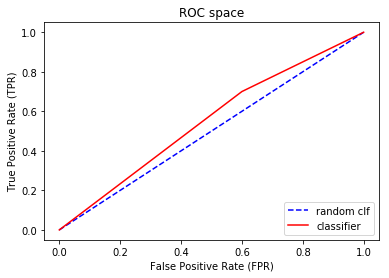

In [108]:
plot_ROC(0.6, 0.7)

## <font color='blue'> 4.1 Dataset tic-tac-toe </font>

Analizamos los diagramas de nuestro clasificador, así como para el clasificador de scikit-learn para el dataset 'tic-tac-toe'.

In [109]:
db_ttt = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ttt_sk = Datos("../ConjuntosDatos/tic-tac-toe.data")

np.random.shuffle(db_ttt.datos)
np.random.shuffle(db_ttt_sk.datos)

preprocess_data(db_ttt_sk)

NB = Clasificador.ClasificadorNaiveBayes()
NB_noLaplace = Clasificador.ClasificadorNaiveBayes(laplace=False)
NBSK = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)

### 4.1.1 Validación simple

Utilizamos en este apartado la estrategia de particionado simple.

In [110]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [111]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        115 |         40 |
+----------+------------+------------+
| PRED NEG |         13 |         24 |
+----------+------------+------------+
Punto espacio ROC: ( 0.625 , 0.8984375 )


In [112]:
fpr_nb_nl, tpr_nb_nl = ROC_Analysis(db_ttt, NB_noLaplace, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         98 |         42 |
+----------+------------+------------+
| PRED NEG |         25 |         27 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6086956521739131 , 0.7967479674796748 )


In [113]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        109 |         47 |
+----------+------------+------------+
| PRED NEG |          9 |         27 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6351351351351351 , 0.923728813559322 )


Las matrices anteriores nos permiten tener una idea, pero lo realmente importante son los siguientes diagramas.

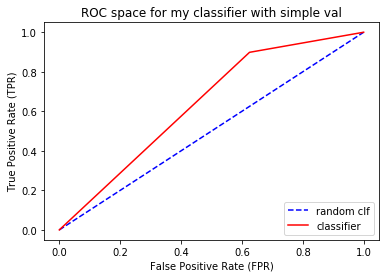

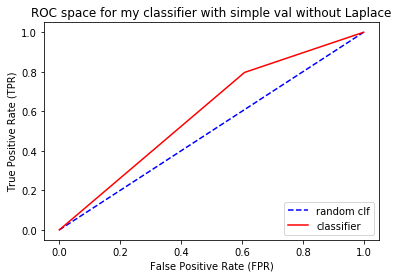

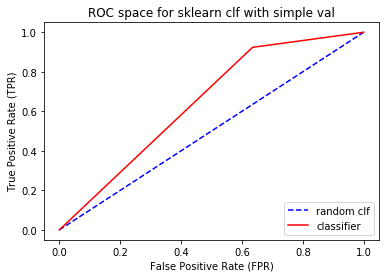

In [114]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nb_nl, tpr_nb_nl, clf_name='my classifier with simple val without Laplace')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with simple val')

Vemos que para ambos clasificadores e independientemente que usemos o no la corrección de Laplace <b>se sitúan por encima de la recta 'clasificador aleatorio'</b>. Es importante observar que los clasificadores tienen un <b>ratio de verdaderos positivos alto</b> (lo cual está bien), pero un <b>ratio de falsos positivos también relativamente alto</b> (lo cual deberíamos mejorar en una práctica más ambiciosa).

### 4.1.2 Validación simple con varias repeticiones

In [115]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [116]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         44 |
+----------+------------+------------+
| PRED NEG |         22 |         19 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6447555812970938 , 0.8025378530970578 )


In [117]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        108 |         34 |
+----------+------------+------------+
| PRED NEG |         18 |         32 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5462027684249907 , 0.8259754771382678 )


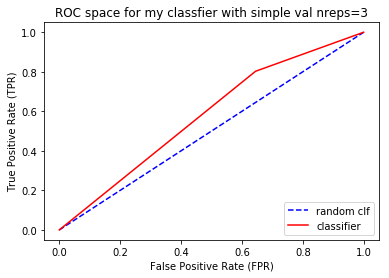

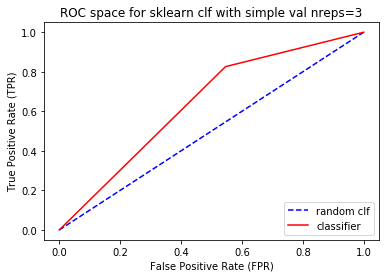

In [118]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classfier with simple val nreps=3')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with simple val nreps=3')

Repetir varias veces la validación simple no aporta ningún cambio de información. Seguimos observando que los clasificadores tienen un <b>ratio de verdaderos positivos alto</b> (lo cual está bien), pero un <b>ratio de falsos positivos también relativamente alto</b>.

### 4.1.3 Validación cruzada

In [119]:
strat_cross_val = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [120]:
fpr_nb, tpr_nb = ROC_Analysis(db_ttt, NB, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        109 |         38 |
+----------+------------+------------+
| PRED NEG |         16 |         28 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5677669953532022 , 0.8484523572754593 )


In [121]:
fpr_nbsk, tpr_nbsk = ROC_Analysis(db_ttt_sk, NBSK, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        106 |         40 |
+----------+------------+------------+
| PRED NEG |         12 |         33 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5868005422971614 , 0.8504791681200567 )


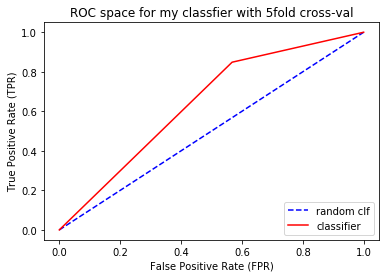

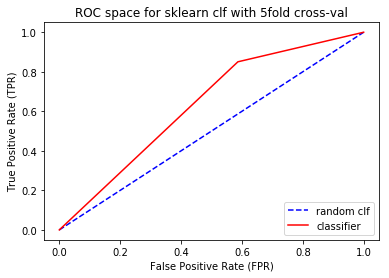

In [122]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classfier with 5fold cross-val')
plot_ROC(fpr_nbsk, tpr_nbsk, clf_name='sklearn clf with 5fold cross-val')

Corroboramos finalmente lo obtenido en los dos últimos subapartados. El análisis ROC de ambos clasificadores <b>son muy similares</b>. Con ratios de verdaderos positivos altos  y ratios de fasos positivos, también altos, pero menores que los verdaderos positivos. 

Como ambos clasificadores tienen resultados <b>parecidos</b>, podríamos considerar que nuestra implementación es correcta y ahora centrarnos en mejorar el algoritmo utilizado para <b>clasificar 'tic-tac-toe'</b>. Por ejemplo, podríamos (en futuros trabajos) intentar utilizar otro algoritmo de aprendizaje automático para ver si desempeña un mejor trabajo con este dataset.

## <font color='blue'> 4.2 Dataset german </font>

Analizamos los diagramas de nuestro clasificador, así como para el clasificador de scikit-learn para el dataset 'german'.

In [123]:
db_ger = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ger_sk_discr = Datos("../ConjuntosDatos/tic-tac-toe.data")
db_ger_sk_cont = Datos("../ConjuntosDatos/tic-tac-toe.data")

np.random.shuffle(db_ger.datos)
np.random.shuffle(db_ger_sk_discr.datos)
np.random.shuffle(db_ger_sk_cont.datos)

preprocess_data(db_ger_sk_discr)

NB = Clasificador.ClasificadorNaiveBayes()
NBSK_discr = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=False)
NBSK_cont = Clasificador.ClasificadorNaiveBayesSK(gaussian_feat=True)

### 4.2.1 Validación simple

In [124]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [125]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        103 |         42 |
+----------+------------+------------+
| PRED NEG |         19 |         28 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6 , 0.8442622950819673 )


In [126]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        113 |         37 |
+----------+------------+------------+
| PRED NEG |         14 |         28 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5692307692307692 , 0.889763779527559 )


In [127]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_simple)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        129 |         51 |
+----------+------------+------------+
| PRED NEG |          1 |         11 |
+----------+------------+------------+
Punto espacio ROC: ( 0.8225806451612904 , 0.9923076923076923 )


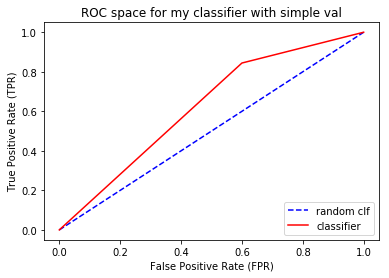

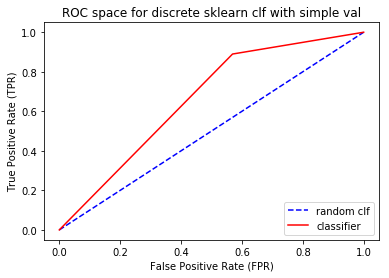

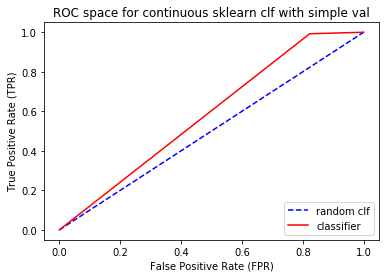

In [128]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with simple val')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with simple val')

Para los dos primeros casos las gráficas son muy similares. Los resultados son buenos, ya que se posiciones por encima de la recta de 'clasificador aleatorio'. No obstante, el punto del espacio ROC de scikit-learn con aproximación de atributos continua tiene un comportamiento visiblemente diferente. Su ratio de verdaderos positivos se ha disparado, acercándose al <b>valor óptimo 1</b>, lo cual es muy bueno. Por desgracia, el valor del ratio de falsos negativos también ha crecido ligeramente. 

Decir si esta variación es positiva dependerá del coste de cometer un falso positivo. Por ejemplo, si <b>elaboramos un sistema de alarma para una central nuclear</b>, puede que nos interese tener una gráfica similar a esta última, ya que un <b>falso positivo no desemboca en altos costes</b> (solo en preocupación para el personal), pero tener una tasa de verdaderos positivos <b>cercana al 100% asegura que en los momentos importantes nuestro sistema no va a fallar</b>. 

### 4.2.2 Validación simple con varias repeticiones

In [99]:
strat_simple_rep3 = EstrategiaParticionado.ValidacionSimple(0.8, nreps=3)

In [100]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |         99 |         41 |
+----------+------------+------------+
| PRED NEG |         24 |         28 |
+----------+------------+------------+
Punto espacio ROC: ( 0.6189613526570048 , 0.852710027100271 )


In [101]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         36 |
+----------+------------+------------+
| PRED NEG |         15 |         34 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5675434362934363 , 0.883672113781606 )


In [102]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_simple_rep3)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        124 |         58 |
+----------+------------+------------+
| PRED NEG |          2 |          8 |
+----------+------------+------------+
Punto espacio ROC: ( 0.8451479076479077 , 0.9808050092017484 )


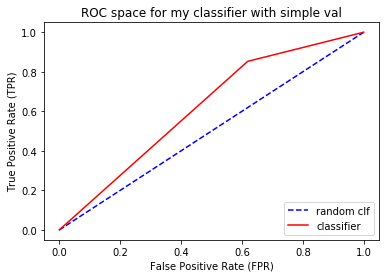

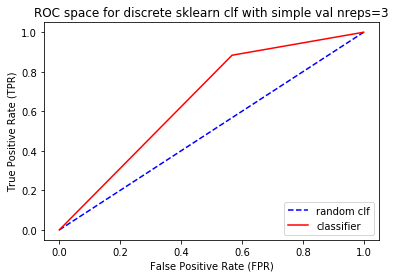

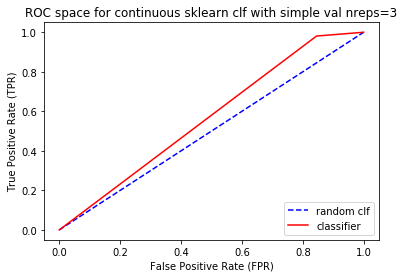

In [103]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with simple val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with simple val nreps=3')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with simple val nreps=3')

Repetir varias veces la validación simple no aporta ningún cambio de información. Seguimos observando que los clasificadores tienen un <b>ratio de verdaderos positivos alto</b> (lo cual está bien), pero un <b>ratio de falsos positivos también relativamente alto</b>.
En la última gráfica, de nuevo, el TPR es altísimo, perdiendo a cambio una pequeña elevación del FPR.

### 4.2.3 Validación cruzada

In [104]:
strat_cross_val = EstrategiaParticionado.ValidacionCruzada(k_fold=5)

In [105]:
fpr_nb, tpr_nb = ROC_Analysis(db_ger, NB, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        103 |         43 |
+----------+------------+------------+
| PRED NEG |         18 |         27 |
+----------+------------+------------+
Punto espacio ROC: ( 0.582024724411377 , 0.8558634971827876 )


In [106]:
fpr_nbsk_discr, tpr_nbsk_discr = ROC_Analysis(db_ger_sk_discr, NBSK_discr, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        107 |         42 |
+----------+------------+------------+
| PRED NEG |         19 |         23 |
+----------+------------+------------+
Punto espacio ROC: ( 0.5707836579447834 , 0.8486480423453665 )


In [107]:
fpr_nbsk_cont, tpr_nbsk_cont = ROC_Analysis(db_ger_sk_cont, NBSK_cont, strat_cross_val)

+----------+------------+------------+
|          |   REAL POS |   REAL NEG |
+==========+============+============+
| PRED POS |        126 |         51 |
+----------+------------+------------+
| PRED NEG |          0 |         14 |
+----------+------------+------------+
Punto espacio ROC: ( 0.79170939033008 , 0.9807775425000305 )


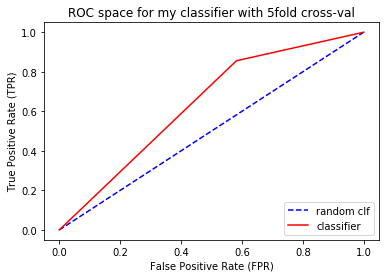

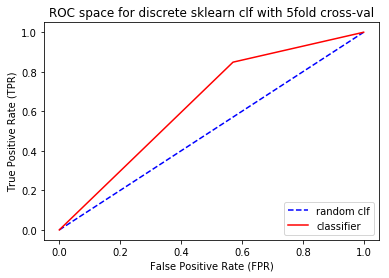

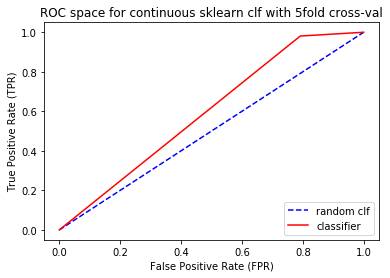

In [108]:
plot_ROC(fpr_nb, tpr_nb, clf_name='my classifier with 5fold cross-val')
plot_ROC(fpr_nbsk_discr, tpr_nbsk_discr, clf_name='discrete sklearn clf with 5fold cross-val')
plot_ROC(fpr_nbsk_cont, tpr_nbsk_cont, clf_name='continuous sklearn clf with 5fold cross-val')

Finalmente, la validación cruzada no aporta más información de la que ya teníamos. Nuestro clasificador es similar al de scikit-learn. Quizá es de sklearn sea mejor en que el coste de un falso negativo sea terriblemente alto (ya que la tasa de verdaderos positivos es cercana al 100%).
Por lo general buscamos tener un equilibrio entre ambas tasas, por lo que en otras situaciones busquemos rendimientos de clasificador similares a los de las primeras dos gráficas.